# OUR CLIENT:
## Charles Christensen  
![](Charles_image.png)
### **Role:** 
#### Seller  
### **Characteristics:**  
#### Wants to invest with big returns.  
#### Unsure about renovation, neighborhood, and timing.

# OUR HYPOTHESES:
![](https://images.ctfassets.net/083zfbgkrzxz/4Igb5KJ4Zty8RKCzy6ZVcM/44493e7964ff7666040ce9be03ca66e0/Blog_Hypothesis_1800x900_071624.png)
### 1. Renovated houses make more profit than non-renovated houses. 
### 2. Houses with prices over average make more profit than houses below average. 
### 3. Sales over time: Sold houses in summer have an higher average price than in winter.

# DATA ANALYSIS
![](https://cdn.prod.website-files.com/68905634ded558175131e904/68905634ded558175131f6dd_Data%20Analysis%20Software%202.webp)

#### Here we do import our libraries:

In [ ]:
import pandas as pd
from matplotlib.ticker import FuncFormatter
from matplotlib.offsetbox import AnchoredText
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter
from matplotlib.colors import PowerNorm
import numpy as np
from matplotlib.dates import MonthLocator, DateFormatter
import calendar
import seaborn as sns



#### Here we do an initial data cleaning, checking what more do we need concerning our data, and check some results:

In [60]:

df_import = pd.read_csv('data/eda.csv')
df_import["date"] = pd.to_datetime(df_import["date"],errors="coerce")
df_import["price_sqft"] = df_import["price"] / df_import["sqft_living"]
df_import["basement_living"] = df_import["sqft_basement"] / df_import["sqft_living"]*100
#============HOW MANY HOUSES DO WE HAVE (TOGETHER WITH DUPLICATED)=====================#
print("Total houses",len(df_import["id"]))

Total houses 21597


#### Here we do divide our sqft living data into bins/clasters:

In [61]:
df_size_bins = df_import[["price","price_sqft","sqft_living"]].copy().reset_index()
bins   = [0, 800, 1200, 1800, 2500, df_size_bins["sqft_living"].max()]
sqft_labels = ["XS","S","M","L","XL"]
df_size_bins["sqft_bin_width"] = pd.cut(df_size_bins["sqft_living"], bins=bins,labels=sqft_labels, include_lowest=True)

#===========================SOME EXTRA COMMANDS TO REMEMBER========================#
#df_size_bins = df_size_bins[df_size_bins["sqft_living"].notna()]
#df_size_bins["bin_mean_price"] = df_size_bins.groupby("sqft_bin_width")["price"].transform("mean")
#df_size_bins["bin_mean_price_sqft"] = df_size_bins.groupby("sqft_bin_width")["price_sqft"].transform("mean")
#==================================================================================#

summary = (
    df_size_bins.groupby("sqft_bin_width", observed=True)
      .agg(bin_mean_price=("price","mean"),
           bin_mean_price_sqft=("price_sqft","mean"))
      .reset_index()
)
print("====================")
print(summary)


  sqft_bin_width  bin_mean_price  bin_mean_price_sqft
0             XS   270464.129897           383.623872
1              S   325927.330289           317.554402
2              M   399809.722519           266.283931
3              L   504003.998555           236.616301
4             XL   863700.805970           256.968907


#### Here we do create boxplot and map for the price:

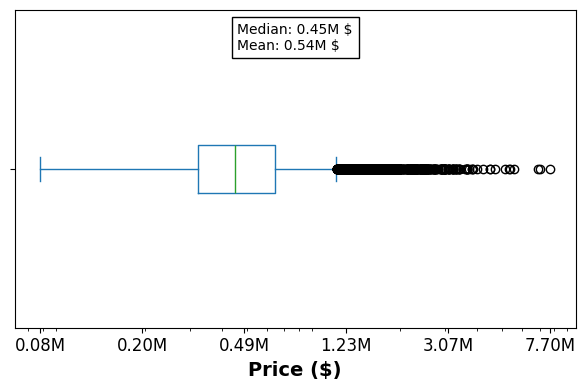

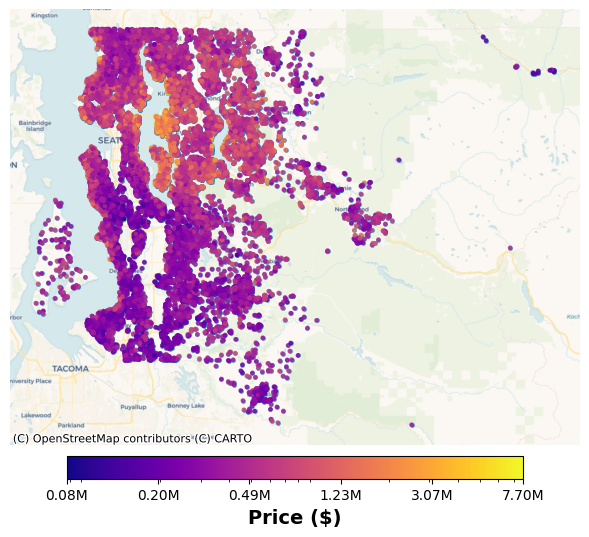

In [62]:
#==========PRICE BOXPLOT=========================#
from matplotlib.ticker import FuncFormatter, NullFormatter

s = df_import["price"].dropna()
median = s.median()
mean   = s.mean()
vmin=df_import["price"].min()
vmax=df_import["price"].max()
ax=df_import[["price"]].plot.box(vert=False, figsize=(6,4))
ax.set_xscale("log")    
ax.set_xlabel("Price ($)", fontsize=14, fontweight="bold")
ticks = np.geomspace(vmin, vmax, num=6)     # 6 ticks, equal spacing on log axis
ax.set_xticks(ticks)
ax.tick_params(axis="x", labelsize=12)
fmt_M = FuncFormatter(lambda x, pos: f"{x/1e6:.2f}M")
ax.xaxis.set_major_formatter(fmt_M)
ax.xaxis.set_minor_formatter(NullFormatter())
txt = f"Median: {median/1e6:.2f}M \\$\nMean: {mean/1e6:.2f}M \\$"
ax.add_artist(AnchoredText(txt, loc="upper center", frameon=True))
ax.set_yticklabels("")
plt.tight_layout()
plt.show()

#==========PRICE MAP===========================#

pts_pr = df_import[['long','lat','price']].dropna().rename(columns={'long':'lon'})
gdf_pr = gpd.GeoDataFrame(pts_pr, geometry=gpd.points_from_xy(pts_pr['lon'], pts_pr['lat']), crs="EPSG:4326").to_crs(3857)
ax_pr = gdf_pr.plot(figsize=(6, 6), markersize=6, alpha=0.7)
vmin=pts_pr["price"].min()
vmax=pts_pr["price"].max()
norm = LogNorm(vmin=vmin, vmax=vmax)
ticks=np.geomspace(vmin, vmax, num=6)
fmt_M = FuncFormatter(lambda x, pos: f"{x/1e6:.2f}M")  # e.g., 0.40M
gdf_pr.plot(
    ax=ax_pr,
    column="price",
    cmap="plasma",
    norm=norm,
    markersize=6,
    alpha=0.7,
    legend=True,
    legend_kwds={
        "orientation": "horizontal",
        "shrink": 0.8,   # shorter bar
        "pad": 0.02,     # closer to the map
        "format":fmt_M,
        "ticks":ticks,
    },
)
cx.add_basemap(ax_pr, source=cx.providers.CartoDB.Voyager)
cax = ax_pr.figure.axes[-1]                 # colorbar axis
cax.set_xlabel("Price ($)", fontsize=14, fontweight="bold")
ax_pr.set_axis_off()
plt.tight_layout()
plt.show()


####  Here we do create boxplot and map for the price per sqft:

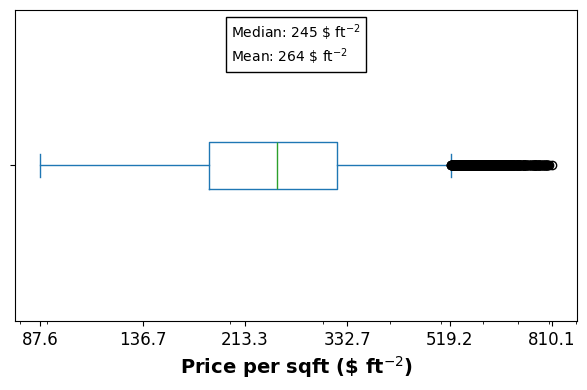

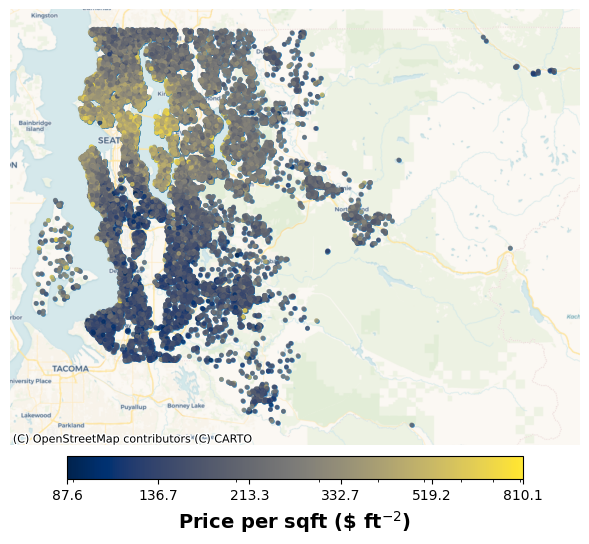

In [63]:
#==========PRICE/SQFT LIVING BOXPLOT=========================#
from matplotlib.ticker import FuncFormatter, NullFormatter,ScalarFormatter

s = df_import["price_sqft"].dropna()
median = s.median()
mean   = s.mean()
vmin=df_import["price_sqft"].min()
vmax=df_import["price_sqft"].max()
ax=df_import[["price_sqft"]].plot.box(vert=False, figsize=(6,4))
ax.set_xscale("log")  
ticks = np.geomspace(vmin, vmax, num=6)     # 6 ticks, equal spacing on log axis
ax.set_xticks(ticks)  
ax.set_xlabel(r"Price per sqft (\$ ft$^{{-2}}$)",fontsize=14, fontweight="bold")
ax.tick_params(axis="x", labelsize=12)
txt = f"Median: {median:,.0f} \$ ft$^{{-2}}$\nMean: {mean:,.0f} \$ ft$^{{-2}}$"
ax.add_artist(AnchoredText(txt, loc="upper center", frameon=True))
ax.set_yticklabels("")
sf = ScalarFormatter()
sf.set_scientific(False)
sf.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(sf)
ax.xaxis.set_minor_formatter(NullFormatter())
plt.tight_layout()
plt.show()

#==========PRICE/SQFT LIVING MAP===========================#

pts_pr = df_import[['long','lat','price_sqft']].dropna().rename(columns={'long':'lon'})
gdf_pr = gpd.GeoDataFrame(pts_pr, geometry=gpd.points_from_xy(pts_pr['lon'], pts_pr['lat']), crs="EPSG:4326").to_crs(3857)
ax_pr = gdf_pr.plot(figsize=(6, 6), markersize=6, alpha=0.7)
vmin=pts_pr["price_sqft"].min()
vmax=pts_pr["price_sqft"].max()
norm = LogNorm(vmin=vmin, vmax=vmax)
ticks=np.geomspace(vmin, vmax, num=6)
gdf_pr.plot(
    ax=ax_pr,
    column="price_sqft",
    cmap="cividis",
    norm=norm,
    markersize=6,
    alpha=0.7,
    legend=True,
    legend_kwds={
        "orientation": "horizontal",
        "shrink": 0.8,   # shorter bar
        "pad": 0.02,     # closer to the map
        "ticks":ticks,
    },
)
cx.add_basemap(ax_pr, source=cx.providers.CartoDB.Voyager)
cax = ax_pr.figure.axes[-1]                 # colorbar axis
cax.set_xlabel(r"Price per sqft (\$ ft$^{{-2}}$)",fontsize=14, fontweight="bold")
sf = ScalarFormatter()
sf.set_scientific(False)
sf.set_powerlimits((0, 0))
cax.xaxis.set_major_formatter(sf)
cax.xaxis.set_minor_formatter(NullFormatter())
ax_pr.set_axis_off()
plt.tight_layout()
plt.show()

#### Here we do check the renovation situation:

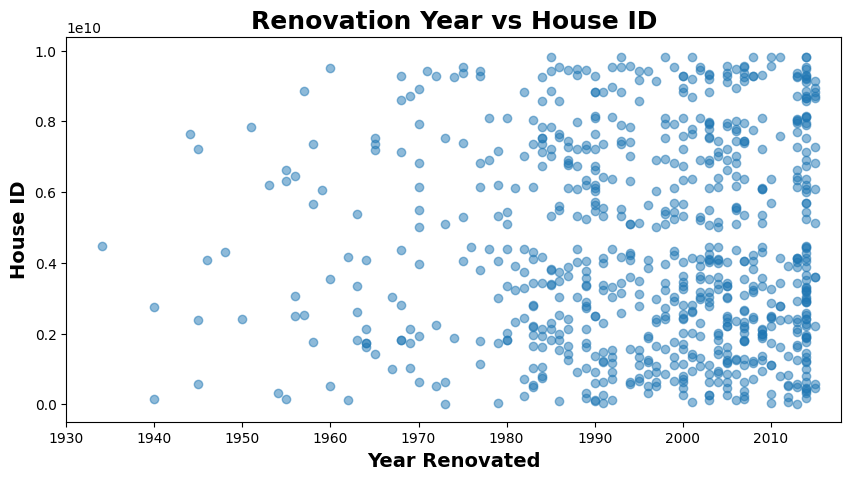

yr_renovated
Modern (1990–2004)        264
Recent (2005–2013)        222
Late 20th C. (1975–89)    164
Mid-Century (1960–74)      52
Old (1945–59)              21
New (2014–15)              14
Very Old (1930–44)          7
Name: count, dtype: int64
             yr_renovated  ren_mean_price  ren_mean_price_sqft  \
0      Very Old (1930–44)   419107.142857           295.279797   
1           Old (1945–59)   500937.142857           310.867096   
2   Mid-Century (1960–74)   503496.250000           258.797417   
3  Late 20th C. (1975–89)   723588.981707           311.198001   
4      Modern (1990–2004)   876338.537879           335.937500   
5      Recent (2005–2013)   777663.540541           330.189867   
6           New (2014–15)   697464.285714           285.486876   

   ren_mean_sqft_living  ren_mean_yr_built  ren_mean_condition  \
0           1511.428571        1914.142857            3.714286   
1           1670.238095        1920.666667            3.571429   
2           2004.038462 

In [64]:
#=================Cleaning renovation data============#

df_import["yr_renovated"] = pd.to_numeric(df_import["yr_renovated"],errors="coerce").astype("Int64")     # convert floats to int
df_import["yr_renovated"] = df_import["yr_renovated"].astype(str)     # to string
df_import["yr_renovated"] = df_import["yr_renovated"].str[:4]         # keep only first 4 chars
df_import["yr_renovated"] = pd.to_numeric(df_import["yr_renovated"],errors="coerce").astype("Int64") 
#print(df_import['yr_renovated'].value_counts(dropna=False).sort_values(ascending=True))

#===============Map of renovation data=================#

plt.figure(figsize=(10,5))
plt.scatter(df_import['yr_renovated'], df_import['id'], alpha=0.5)
plt.xlim(1930, 2018)
plt.xlabel("Year Renovated",fontsize=14, fontweight="bold")
plt.ylabel("House ID",fontsize=14, fontweight="bold")
plt.title("Renovation Year vs House ID",fontsize=18, fontweight="bold")
plt.show()

#=============Clustering renovation data================#

df_ren_bins = df_import[["id","view","price", "date","yr_renovated","yr_built","condition","grade","sqft_living","sqft_lot","floors","price_sqft","basement_living","waterfront"]].copy().reset_index()
bins = np.arange(1930, 2015,15)
extra_years = [2014,2015]
bins = np.sort(np.concatenate([bins, extra_years])) 
labels = [
    "Very Old (1930–44)",
    "Old (1945–59)",
    "Mid-Century (1960–74)",
    "Late 20th C. (1975–89)",
    "Modern (1990–2004)",
    "Recent (2005–2013)",
    "New (2014–15)"
]
df_ren_bins["yr_renovated"] = pd.cut(df_ren_bins["yr_renovated"], bins=bins,labels=labels, include_lowest=True)
print(df_ren_bins["yr_renovated"].value_counts())

summary = (
    df_ren_bins.groupby("yr_renovated", observed=True)
      .agg(ren_mean_price=("price","mean"),
           ren_mean_price_sqft=("price_sqft","mean"),
           ren_mean_sqft_living=("sqft_living","mean"),
           ren_mean_yr_built=("yr_built", "mean"),
           ren_mean_condition=("condition", "mean"),
           ren_mean_grade=("grade", "mean"),
           ren_mean_sqft_lot=("sqft_lot", "mean"),
           ren_mean_floors=("floors", "mean"),
           ren_mean_basement_living=("basement_living", "mean"),
           ren_mean_waterfront=("waterfront", "mean"),
           ren_mean_view=("view", "mean"))
      .reset_index()
)
print("====================")
print(summary)



#### Here we do check characteristics of the all the renovated houses:

In [67]:
#===========Handle renovated houses=============#

df_ren = df_import[df_import["yr_renovated"] > 0].copy()
df_ren = df_ren[["id", "view","price", "date","yr_renovated","yr_built","condition","grade","sqft_living","sqft_lot","floors","price_sqft","basement_living","waterfront"]]
df_ren_avg = (df_ren.median(numeric_only=True))
print("avg_of_ren:",df_ren_avg)
#print(df_import.mean())




avg_of_ren: id                 3899100167.5
view                        0.0
price                  607502.0
yr_renovated             2000.0
yr_built                 1941.5
condition                   3.0
grade                       8.0
sqft_living              2200.0
sqft_lot                 7375.0
floors                      1.5
price_sqft           301.562882
basement_living        9.259259
waterfront                  0.0
dtype: Float64


#### Here we do check characteristics of the all the NON-renovated houses:

In [68]:
df_non_ren = df_import[df_import["yr_renovated"] == 0].copy()
df_non_ren = df_non_ren[["id", "view","price", "date","yr_renovated","yr_built","condition","grade","sqft_living","sqft_lot","floors","price_sqft","basement_living","waterfront"]]
df_non_ren_avg = (df_non_ren.median(numeric_only=True))
print("avg_of_non_ren:",df_non_ren_avg)


avg_of_non_ren: id                 3905010100.0
view                        0.0
price                  448000.0
yr_renovated                0.0
yr_built                 1977.0
condition                   3.0
grade                       7.0
sqft_living              1910.0
sqft_lot                 7616.0
floors                      1.5
price_sqft           242.765273
basement_living             0.0
waterfront                  0.0
dtype: Float64


#### How many renovated and NON-renovated do we have? How many duplicates (meaning profit) into them?:

In [69]:
###======HOW MANY RENOVATED????===============#####

df_ren = df_ren.sort_values(["id", "date"])
print("how many ren:  ",len(df_ren["id"]))
df_non_ren = df_non_ren.sort_values(["id", "date"])
print("how many non ren:  ",len(df_non_ren["id"]))

###===============HOW MANY RENOVATED DUPLICATES ???? (data for possible profit)============#####

df_dups = df_import[df_import.duplicated("id", keep=False)].copy()
df_dups["renovated_flag"] = df_dups["yr_renovated"] > 0
#print(df_dups)
#print(df_dups.groupby("id")["yr_renovated"].nunique().value_counts())
renovation_status = df_dups.groupby("id")["yr_renovated"].unique()
vals = df_dups.groupby("id")["yr_renovated"].apply(lambda s: set(s.dropna()))
#======HERE IT KEEPS EVERY ID ONCE!!!!=========#
never  = vals[vals.apply(lambda s: s == {0})]
always = vals[vals.apply(lambda s: len(s) > 0 and 0 not in s)] 
both   = vals[vals.apply(lambda s: 0 in s and any(v > 0 for v in s))]
unknown = vals[vals.apply(lambda s: len(s) == 0)]  # only NaNs
print("Duplicated renovated houses:", len(always))
print("duplicated non renovated houses:", len(never))


how many ren:   744
how many non ren:   17005
Duplicated renovated houses: 4
duplicated non renovated houses: 136


#### Calculating the price per cluster in duplicates:

In [70]:
#==========Consistent renovated flag (exclude NaNs; renovated if yr_renovated > 0)======#
ren_flag = df_import["yr_renovated"].notna() & (df_import["yr_renovated"] > 0)

mean_ren_all  = df_import.loc[ren_flag, "price"].mean()
mean_non_all  = df_import.loc[df_import["yr_renovated"] == 0, "price"].mean()
diff_ren=(mean_ren_all-mean_non_all)*100/(mean_non_all)


df_dups = df_import[df_import.duplicated("id", keep=False)].copy()
df_dups["renovated"] = df_dups["yr_renovated"].notna() & (df_dups["yr_renovated"] > 0)

mean_ren_dups = df_dups.loc[df_dups["renovated"], "price"].mean()
mean_non_dups = df_dups.loc[df_dups["yr_renovated"] == 0, "price"].mean()
diff_ren_dups=(mean_ren_dups-mean_non_dups)*100/(mean_non_dups)


# Count how many times each id appears
id_counts = df_import['id'].value_counts()

# Get the id with the maximum count
max_id = id_counts.idxmax()
max_count = id_counts.max()

print(f"ID with max count: {max_id}, appears {max_count} times")

# Filter rows for that id
df_max_id = df_import[df_import['id'] == max_id]

print("=====================")
print("=====================")

print(df_max_id[['zipcode','price', 'date']])

print("=====================")
print("=====================")

print("number of duplicates (NAN,number,0):   ",len(df_dups["id"]),"total number - all the id-dups")
print("Price— renovated:", mean_ren_all)
print("Price — non-renovated:", mean_non_all)
print("Price in renovated is higher than",diff_ren.round(0),"%")
print("Price — renovated (dup):", mean_ren_dups)
print("Price — non-renovated (dup):", mean_non_dups)
print("Price in renovated dups is lower than",diff_ren_dups.round(0),"%")


#===========CLUSTERING THE DUP===========#
bin_dups = df_dups[["id", "date", "price","yr_renovated","zipcode","condition","sqft_living","sqft_lot",
                      "yr_built","floors","grade","lat","long","price_sqft",
                      "basement_living","waterfront"]].copy().reset_index()
bins = np.arange(1930, 2015,15)
extra_years = [2014,2015]
bins = np.sort(np.concatenate([bins, extra_years])) 
labels = [
    "Very Old (1930–44)",
    "Old (1945–59)",
    "Mid-Century (1960–74)",
    "Late 20th C. (1975–89)",
    "Modern (1990–2004)",
    "Recent (2005–2013)",
    "New (2014–15)"
]
bin_dups["yr_renovated"] = pd.cut(bin_dups["yr_renovated"], bins=bins,labels=labels, include_lowest=True)
print("=====================")
print("=====================")
print("How many renovated dups in each bin:")
print(bin_dups["yr_renovated"].value_counts().sort_index())

ID with max count: 795000620, appears 3 times
       zipcode     price       date
17588    98168  115000.0 2014-09-24
17589    98168  124000.0 2014-12-15
17590    98168  157000.0 2015-03-11
number of duplicates (NAN,number,0):    353 total number - all the id-dups
Price— renovated: 768901.8924731183
Price — non-renovated: 530952.2381652455
Price in renovated is higher than 45.0 %
Price — renovated (dup): 410200.0
Price — non-renovated (dup): 439350.01102941175
Price in renovated dups is lower than -7.0 %
How many renovated dups in each bin:
yr_renovated
Very Old (1930–44)        0
Old (1945–59)             0
Mid-Century (1960–74)     2
Late 20th C. (1975–89)    6
Modern (1990–2004)        0
Recent (2005–2013)        0
New (2014–15)             0
Name: count, dtype: int64


#### Profit calculation:

In [71]:
mask = df_import["date"].isna()
#print(mask)
#print(df_import.loc[mask, ["id", "date", "price"]])


# 0) duplicates only
df_dups = df_import[df_import.duplicated("id", keep=False)].copy()

# 1) make sure dates are datetime and sort within each id
df_dups = df_dups.dropna(subset=["date"])  # drop rows with missing date for ordering
df_dups = df_dups.sort_values(["id", "date"])
#print(df_dups["yr_renovated"].value_counts(dropna=False))



# -------------------------------------------------------
# A) Consecutive diffs within each id (new - previous)
# -------------------------------------------------------
step_diffs = df_dups[["bedrooms","sqft_living15","sqft_lot15","view","id", "date", "price","yr_renovated","zipcode","condition","sqft_living","sqft_lot","yr_built","floors","grade","lat","long","price_sqft","basement_living","waterfront"]].copy().reset_index()
#diff_from_prev = step_diffs.groupby("id")[["price"]].diff()
# earliest row per id, then mean of its price
#====INITIAL PRICE======#
first_per_id = (step_diffs
                .sort_values(['id','date'])
                .groupby('id', as_index=False)
                .first())


#print(step_diffs["id"])

mean_initial_price = first_per_id['price'].mean()
median_initial_price = first_per_id['price'].median()
mean_total_price=df_import['price'].mean()





first_price     = df_dups.groupby("id")["price"].first()
last_price = df_dups.groupby("id")["price"].last()
pct_first  = (last_price - first_price) / first_price * 100
diff_first  = (last_price - first_price) 
df_dups["pct_initial_to_last"] = df_dups["id"].map(pct_first)
df_dups["diff_initial_to_last"] = df_dups["id"].map(diff_first)

rows_table = step_diffs.loc[:, ["zipcode","bedrooms","id","sqft_living15","sqft_lot15","view","condition","sqft_living","sqft_lot","yr_renovated","yr_built","floors","grade","price","lat","long","price_sqft","basement_living","waterfront"]].copy()
rows_table["pct_initial_to_last"] = df_dups["pct_initial_to_last"].values
rows_table["diff_initial_to_last"] = df_dups["diff_initial_to_last"].values

#================= BE CAREFUL ====>
#=====APART FROM PRICE AND PRICE SQFT 
#=====THE OTHER COLUMNS HAVE IDENTICAL VALUES PER ID
#=====WE HAVE TO EXLCUDE THEM FROM MEAN 
#=====OTHERWISE IN TOTAL MEAN WE'LL ADD CONTIDION FOR EXAMPLE 3 TIMES PER ID (THE SAME VALUE 3 TIMES)
#=====THIS WILL CHANGE THE TOTAL MEAN OF CONDITION

cols  = rows_table.columns.drop(["id", "price", "price_sqft"])

# first row per id
first = rows_table.groupby("id").cumcount().eq(0)

# True where a column is constant within that id
constant_within_id = rows_table[cols].groupby(rows_table["id"]).transform("nunique").eq(1)

# Build a pure numpy mask: rows that are NOT first AND column is constant -> blank
mask = (~first.values)[:, None] & constant_within_id.values

#Blank (set NaN) where mask is True
rows_table[cols] = rows_table[cols].mask(mask)


print(rows_table)





top_map = rows_table.nlargest(30, "pct_initial_to_last")
last_map = rows_table.nsmallest(30, "pct_initial_to_last")

top_map_sqft_price = rows_table.nlargest(30, "pct_initial_to_last")
last_map_sqft_price = rows_table.nsmallest(30, "pct_initial_to_last")
#print(last100_map_sqft_price)



print("===================")
print("top_30_mean_profit")
print("===================")
print(top_map.mean())
print("===================")
print("===================")
print("===================")
print("last_30_mean_profit")
print("===================")
print(last_map.mean())
print("===================")
print("===================")
print("===================")



overall_profit = rows_table[["sqft_living15","sqft_lot15","pct_initial_to_last","condition","sqft_living","sqft_lot","yr_built","floors","grade","price","price_sqft"]].mean(numeric_only=True)
print(overall_profit)

diff_pct_profits_top = ((top_map - overall_profit["pct_initial_to_last"]) / overall_profit["pct_initial_to_last"] * 100).round(2)
diff_pct_profits_last = ((last_map - overall_profit["pct_initial_to_last"]) / overall_profit["pct_initial_to_last"] * 100).round(2)
print("profit per overal profit of top 50 : ",diff_pct_profits_top['pct_initial_to_last'].mean().round(2),"%")
print("profit per overal profit of last 50 : ",diff_pct_profits_last['pct_initial_to_last'].mean().round(2),"%")

     zipcode  bedrooms          id  sqft_living15  sqft_lot15  view  \
0    98002.0       6.0     1000102         2060.0      7316.0   0.0   
1        NaN       NaN     1000102            NaN         NaN   NaN   
2    98055.0       2.0     7200179         1480.0      6969.0   0.0   
3        NaN       NaN     7200179            NaN         NaN   NaN   
4    98023.0       3.0   109200390         1830.0      6956.0   0.0   
..       ...       ...         ...            ...         ...   ...   
348      NaN       NaN  9828200460            NaN         NaN   NaN   
349  98144.0       3.0  9834200305         1360.0      4080.0   0.0   
350      NaN       NaN  9834200305            NaN         NaN   NaN   
351  98144.0       4.0  9834200885         1340.0      4080.0   0.0   
352      NaN       NaN  9834200885            NaN         NaN   NaN   

     condition  sqft_living  sqft_lot  yr_renovated  ...  floors  grade  \
0          3.0       2400.0    9373.0             0  ...     2.0    7.0 

### Calculation of top30 median profit (in $) values:

In [72]:
top30_profit = rows_table.nlargest(10, "diff_initial_to_last")
print("Median of top30")
print(top30_profit[["sqft_living", "sqft_lot", "yr_built", "price", "bedrooms","floors", "price_sqft", "grade", "condition", "basement_living"]].median(numeric_only=True).round(2))
#print("Last 30 Mittelwerte:")

last30_profit = rows_table.nsmallest(10, "diff_initial_to_last")
print("Median of last30")
print(last30_profit[["sqft_living", "sqft_lot", "yr_built", "price", "bedrooms","floors", "price_sqft", "grade", "condition", "basement_living"]].median(numeric_only=True).round(2))

#print(last30_profit[["sqft_living", "sqft_lot", "yr_built", "price", "bedrooms","floors", "price_sqft", "grade", "condition", "basement_living"]].median(numeric_only=True).round(2))


# TOP10 PROFIT WITH ZIPCODES
top_profit_rows = rows_table.nlargest(10, "diff_initial_to_last")[["diff_initial_to_last", "zipcode"]]
#print(top_profit_rows)

# MEDIAN IN PROFIT PER ZIPCODE
avg_abs_profit_per_zip = rows_table.groupby("zipcode")["diff_initial_to_last"].median()
best_zipcode_abs = avg_abs_profit_per_zip.idxmax()
best_profit_abs = avg_abs_profit_per_zip.max()
print(f"ZIP code with the highest average absolute profit: {best_zipcode_abs} ({best_profit_abs:.2f} $)")


zip_counts = rows_table["zipcode"].value_counts()
valid_zipcodes = zip_counts[zip_counts >= 3].index


# only ZIP codes with at least 3 entries
zip_counts = rows_table["zipcode"].value_counts()
valid_zipcodes = zip_counts[zip_counts >= 3].index

avg_abs_profit_per_zip = (
    rows_table[rows_table["zipcode"].isin(valid_zipcodes)]
    .groupby("zipcode")["diff_initial_to_last"]
    .median()
    .sort_values(ascending=False)
)

print("ZIP codes with at least 3 entries and their average profit")
print(avg_abs_profit_per_zip)


Median of top30
sqft_living          1490.00
sqft_lot             7212.50
yr_built             1944.50
price              347500.00
bedrooms                2.50
floors                  1.00
price_sqft            178.73
grade                   7.00
condition               3.00
basement_living        17.18
dtype: float64
Median of last30
sqft_living          2115.0
sqft_lot             4248.0
yr_built             2002.5
price              552500.0
bedrooms                3.0
floors                  2.0
price_sqft            260.4
grade                   8.0
condition               3.0
basement_living         0.0
dtype: float64
ZIP code with the highest average absolute profit: 98148.0 (339500.00 $)
ZIP codes with at least 3 entries and their average profit
zipcode
98117.0    270000.0
98118.0    247000.0
98115.0    227000.0
98074.0    215875.0
98155.0    214250.0
98144.0    190000.0
98133.0    180000.0
98166.0    169862.5
98146.0    135700.0
98055.0    132500.0
98125.0    130000.0
98106.0

### Here we do create a map for the top and last in profit:

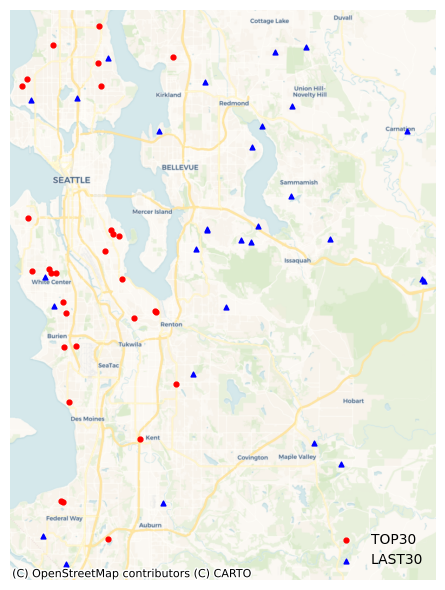

In [73]:
##----------------------------------MAP!!!!!!!!!!!!########



# --- Build GDF 1 ---
pts1 = top_map[['long','lat']].dropna().rename(columns={'long':'lon'})
gdf1 = gpd.GeoDataFrame(
    pts1, geometry=gpd.points_from_xy(pts1['lon'], pts1['lat']),
    crs="EPSG:4326"
).to_crs(3857)

# --- Build GDF 2 (replace df_other with your second table) ---
pts2 = last_map[['long','lat']].dropna().rename(columns={'long':'lon'})
gdf2 = gpd.GeoDataFrame(
    pts2, geometry=gpd.points_from_xy(pts2['lon'], pts2['lat']),
    crs="EPSG:4326"
).to_crs(3857)

# --- Plot both on the same map ---
fig, ax = plt.subplots(figsize=(6,6))

# dataset A (red dots)
gdf1.plot(ax=ax, markersize=12, color='red', alpha=1, marker='o', label='TOP30')

# dataset B (blue triangles)
gdf2.plot(ax=ax, markersize=12, color='blue', alpha=1, marker='^', label='LAST30')

# frame / extent: union of both layers + tiny padding
xmin1, ymin1, xmax1, ymax1 = gdf1.total_bounds
xmin2, ymin2, xmax2, ymax2 = gdf2.total_bounds
xmin, ymin = min(xmin1, xmin2), min(ymin1, ymin2)
xmax, ymax = max(xmax1, xmax2), max(ymax1, ymax2)
pad_x = (xmax - xmin) * 0.03
pad_y = (ymax - ymin) * 0.03
ax.set_xlim(xmin - pad_x, xmax + pad_x)
ax.set_ylim(ymin - pad_y, ymax + pad_y)

# basemap and cosmetics
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
ax.legend(frameon=False, loc="lower right")
ax.set_axis_off()
plt.tight_layout()
plt.show()



### General map of profit:

-40000.0
529950.0


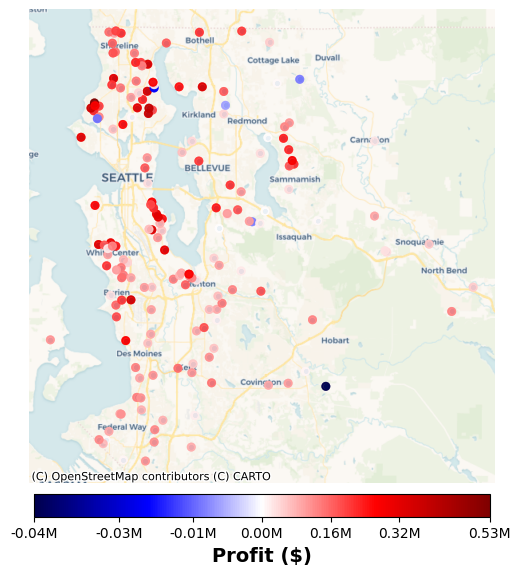

In [74]:
#==========PROFIT MAP===========================#
from matplotlib.colors import TwoSlopeNorm


# 1) coords from the other table
pts_pr_all = df_import[['id','long','lat']].dropna().rename(columns={'long':'lon'})

# 2) start from prices, bring in coords by id
pts_pr = rows_table[['id','diff_initial_to_last']].merge(pts_pr_all, on='id', how='left')

# 3) build GeoDataFrame (use coords from pts_pr itself)
gdf_pr = gpd.GeoDataFrame(
    pts_pr, geometry=gpd.points_from_xy(pts_pr['lon'], pts_pr['lat']),
    crs="EPSG:4326").to_crs(3857)
ax_pr = gdf_pr.plot(figsize=(6, 6), markersize=6, alpha=0.7)
vmin=pts_pr["diff_initial_to_last"].min()
print(vmin)
vmax=pts_pr["diff_initial_to_last"].max()
print(vmax)
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
ticks=[vmin,-25000,-12000,0,160000,320000,vmax]
fmt_M = FuncFormatter(lambda x, pos: f"{x/1e6:.2f}M") 
gdf_pr.plot(
    ax=ax_pr,
    column="diff_initial_to_last",
    cmap="seismic",
    markersize=30,
    norm=norm,
    alpha=0.7,
    legend=True,
    legend_kwds={
        "orientation": "horizontal",
        "shrink": 0.8,   # shorter bar
        "pad": 0.02,     # closer to the map
        "ticks":ticks,
        "format":fmt_M
    },
)
cx.add_basemap(ax_pr, source=cx.providers.CartoDB.Voyager)
cax = ax_pr.figure.axes[-1]                 # colorbar axis
cax.set_xlabel("Profit ($)", fontsize=14, fontweight="bold")
ax_pr.set_axis_off()
plt.tight_layout()
plt.show()

### Here we do a plot concerning the profits and the initial price over time (2014-2015):

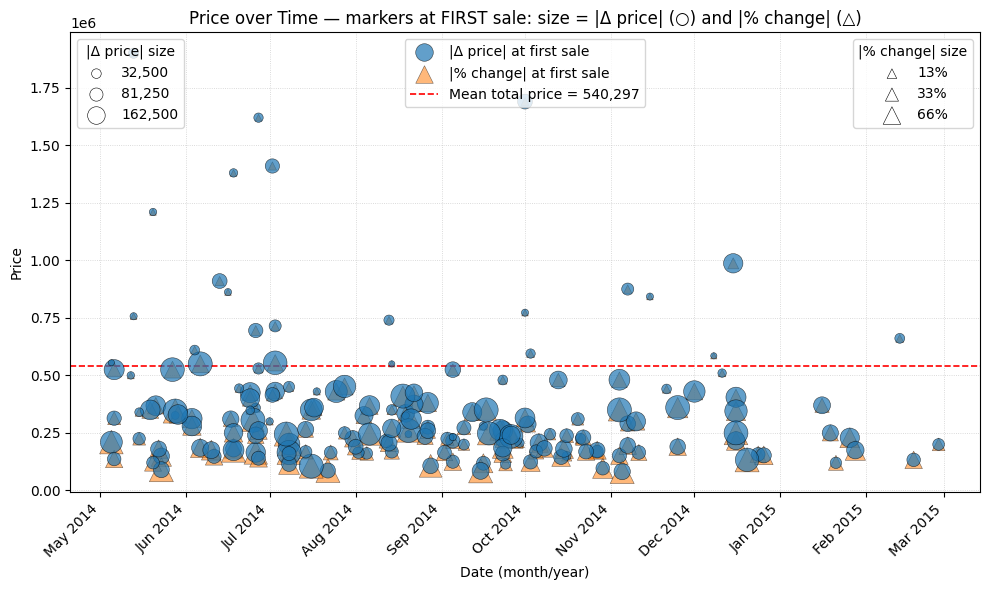

In [75]:
df = step_diffs.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["id", "date", "index"]).reset_index(drop=True)

# rank rows within each id and pick first-sale rows
rank = df.groupby("id").cumcount()
is_first = rank.eq(0)
first_idx = is_first[is_first].index               # indices of first-sale rows
first_sales = df.loc[first_idx]

# LAST PRICE MINUS FIRST PRICE - TOTAL PROFIT OF A HOUSE AFTER MULTIPLE SALES
first_price     = df.groupby("id")["price"].first()
last_price = df.groupby("id")["price"].last()
pct_first  = (last_price - first_price) / first_price * 100
diff_first  = (last_price - first_price) 
#print(pct_first)
# per-id value to all rows in df
df["pct_initial_to_last"] = df["id"].map(pct_first)
#print(df["id"].map(pct_first))
df["diff_initial_to_last"] = df["id"].map(diff_first)


# If mismatched:
# pull the values *at the first-sale rows* (index-aligned!)
diff_first = df["diff_initial_to_last"].loc[first_idx]
pct_first  = df["pct_initial_to_last"].loc[first_idx]

# ---- sizes (use absolute magnitude, clip 95% to keep sizes readable) ----
abs_diff = diff_first.abs()
hi_diff  = abs_diff.quantile(0.95)
hi_diff  = hi_diff if np.isfinite(hi_diff) and hi_diff > 0 else 1.0
sizes_diff = 20 + (abs_diff.clip(upper=hi_diff) / hi_diff).fillna(0) * 280  # 20..300

abs_pct = pct_first.abs()
hi_pct  = abs_pct.quantile(0.95)
hi_pct  = hi_pct if np.isfinite(hi_pct) and hi_pct > 0 else 1.0
sizes_pct = 20 + (abs_pct.clip(upper=hi_pct) / hi_pct).fillna(0) * 280      # 20..300

# masks (still aligned to first_idx)
m_diff = diff_first.notna()
m_pct  = pct_first.notna()

# ---- plot ----
fig, ax = plt.subplots(figsize=(10, 6))

# context line
#ax.plot(first_sales["date"], first_sales["price"], linewidth=1.0, alpha=0.5, label="Price")

# optional small anchors showing first-sale positions
#ax.scatter(first_sales["date"], first_sales["price"], s=10, alpha=0.4, label="First sale (pos)")

# circles: |Δ price| at FIRST sale
ax.scatter(first_sales.loc[m_diff, "date"], first_sales.loc[m_diff, "price"],
           s=sizes_diff[m_diff], alpha=0.7, edgecolor="k", linewidth=0.4, marker="o",
           label="|Δ price| at first sale", zorder=3)

# triangles: |% change| at FIRST sale
ax.scatter(first_sales.loc[m_pct, "date"], first_sales.loc[m_pct, "price"],
           s=sizes_pct[m_pct], alpha=0.55, edgecolor="k", linewidth=0.4, marker="^",
           label="|% change| at first sale", zorder=2)

# mean line
ax.axhline(mean_total_price, color="red",linestyle="--", linewidth=1.2, label=f"Mean total price = {mean_total_price:,.0f}")
#ax.axhline(mean_initial_price, color="blue",linestyle="--", linewidth=1.2, label=f"Mean initial price = {mean_initial_price:,.0f}")
#ax.axhline(median_initial_price, color="red",linestyle="--", linewidth=1.6, label=f"Median initial price = {median_initial_price:,.0f}")


# x-axis formatting
ax.xaxis.set_major_locator(MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.set_xlabel("Date (month/year)")
ax.set_ylabel("Price")
ax.set_title("Price over Time — markers at FIRST sale: size = |Δ price| (○) and |% change| (△)")

# legends for size scales
# DIFF legend
legend_diffs = [0.1*hi_diff, 0.25*hi_diff, 0.5*hi_diff]
legend_sizes_diff = 20 + (np.array(legend_diffs) / hi_diff) * 280
legend_sizes_diff = np.clip(legend_sizes_diff, 20, 300)

handles_diff = [
    plt.scatter([], [], s=legend_sizes_diff[i], marker="o",
                edgecolor="k", facecolor="none", linewidth=0.4)
    for i in range(len(legend_diffs))
]
labels_diff = [f"{val:,.0f}" for val in legend_diffs]   # ← fixed
# Or add currency: labels_diff = [f"€{val:,.0f}" for val in legend_diffs]
leg_diff = ax.legend(handles_diff, labels_diff, title="|Δ price| size",
                     loc="upper left", frameon=True)

# PCT legend
legend_pcts = [0.1*hi_pct, 0.25*hi_pct, 0.5*hi_pct]
legend_sizes_pct = 20 + (np.array(legend_pcts) / hi_pct) * 280
legend_sizes_pct = np.clip(legend_sizes_pct, 20, 300)

handles_pct = [
    plt.scatter([], [], s=legend_sizes_pct[i], marker="^",
                edgecolor="k", facecolor="none", linewidth=0.4)
    for i in range(len(legend_pcts))
]
labels_pct = [f"{val:.0f}%" for val in legend_pcts]      # ← fixed
leg_pct = ax.legend(handles_pct, labels_pct, title="|% change| size",
                    loc="upper right", frameon=True)


ax.add_artist(leg_diff)
ax.add_artist(leg_pct)
ax.legend(loc="upper center", frameon=True)

ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.tight_layout()
plt.show()

### Profits (in $) from renovated and waterfront:

In [78]:
#==================================================================================#
#===============PROFIT FROM RENOVATED==============#
#==================================================================================#

ren_flag = rows_table["yr_renovated"].notna() & (rows_table["yr_renovated"] > 0)
median_ren_all  = rows_table.loc[ren_flag].median()
print("median renovated profit in $",median_ren_all["diff_initial_to_last"])
median_non_all  = rows_table.loc[df_import["yr_renovated"] == 0].mean()
print("median non renovated profit in $",median_non_all["diff_initial_to_last"])




#==================================================================================#
#==========PROFIT FROM WATERFRONT==============#
#==================================================================================#

#===============Cleaning data in waterfront===================#
rows_table["waterfront"] = pd.to_numeric(rows_table["waterfront"],errors="coerce").astype("Int64")

#=============================================================#
waterfront     = rows_table[rows_table["waterfront"]==0].reset_index(drop=True)
waterfront_non = rows_table[rows_table["waterfront"].isna()].reset_index(drop=True)

median_wtr=waterfront["diff_initial_to_last"].median()
median_wtr_non=waterfront_non["diff_initial_to_last"].median()

print("median profit from wtr in $",median_wtr)
print("median profit from NON wtr in $",median_wtr_non)


#CHECK VIEW OF THE DUPLICATES#
rows_table["view"] = pd.to_numeric(rows_table["view"],errors="coerce").astype("Int64")
print(rows_table['view'].value_counts())






median renovated profit in $ 42800.0
median non renovated profit in $ 141967.35251798562
median profit from wtr in $ 118875.0
median profit from NON wtr in $ 119950.0
view
0    168
3      3
4      3
2      1
1      1
Name: count, dtype: Int64


### Here we do calculate price and price/sqft during months:

In [79]:

#==================================================================================#

#####----MONTHLY THINGS (SUCH AS PRICE ETC)----------####

#==================================================================================#


#df_import["year_month_str"] = df_import["date"].dt.strftime("%Y-%m")
#df_import["year_month_timestamp"] = df_import["date"].dt.to_period("M").dt.to_timestamp()
df_import["year_month"] = df_import["date"].dt.to_period("M")
df_import['month_group'] = pd.to_datetime(df_import["date"], format="%B").dt.month
df_import['month'] = df_import['date'].dt.strftime('%m')
df_month= df_import.groupby("month_group")[["price","price_sqft"]].mean().reset_index()
avg_price=df_month["price"].mean()
df_month["diff_from_avg (%)"] = (df_month["price"] - avg_price) / avg_price * 100
df_month["diff_from_avg (%)"]=df_month["diff_from_avg (%)"].round(2)
print(df_month)


#print(renovated_steps["zipcode"].nunique())
zipcode_avg= df_import.groupby("zipcode")[["price","sqft_living","sqft_lot","yr_built","floors","grade","condition","lat","long","price_sqft"]].mean().reset_index()
#print("ren:   ",month_re_steps)
#print(zipcode_avg)


top20_zip = zipcode_avg.nlargest(20, "price").mean()
last20_zip = zipcode_avg.nsmallest(20, "price").mean()
#print("=============")
#print(top20_zip)
#print("=============")
#print(last20_zip)
overall = df_import[["price","sqft_living","sqft_lot","yr_built","floors","grade","condition"]].mean(numeric_only=True)
diff_pct = ((top20_zip - overall) / overall * 100).round(2)
#print(top20_zip)
#print(diff_pct)



    month_group          price  price_sqft  diff_from_avg (%)
0             1  525963.251534  256.773212              -2.10
1             2  508520.051323  259.770095              -5.35
2             3  544057.683200  273.811231               1.27
3             4  562215.615074  278.835612               4.65
4             5  550849.746893  269.110846               2.53
5             6  557534.318182  264.809163               3.78
6             7  544892.161013  259.691581               1.42
7             8  536655.212481  259.889913              -0.11
8             9  529723.517787  259.378960              -1.40
9            10  539439.447228  262.402144               0.41
10           11  522359.903478  258.495379              -2.77
11           12  524799.902041  254.685079              -2.32


### Barplot for median price per time:

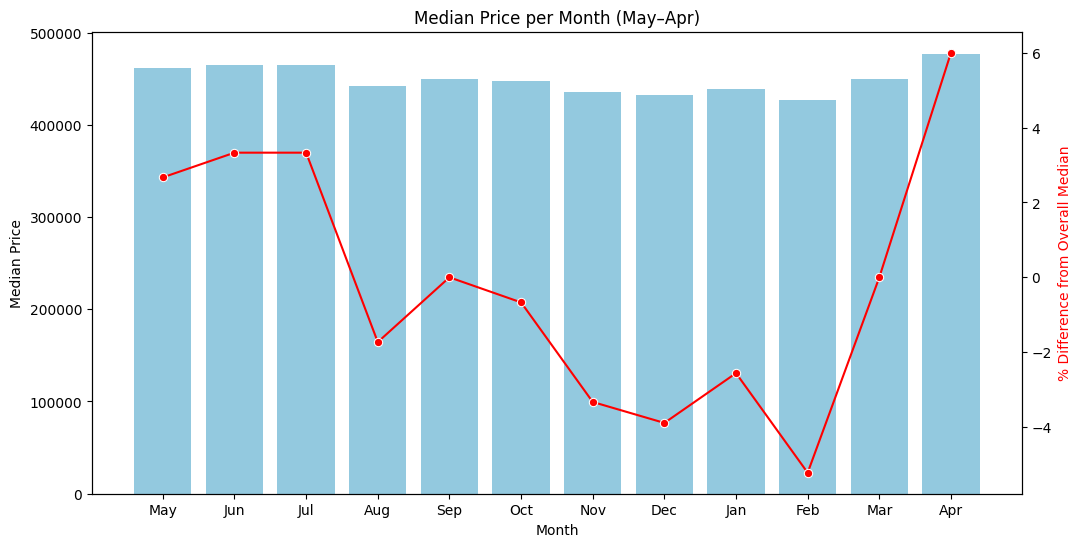

In [80]:
# Monat als Zahl extrahieren
df_import["month"] = df_import["date"].dt.month
df_import["month_name"] = df_import["month"].apply(lambda x: calendar.month_abbr[x])

# Monate von Mai bis Mai (ohne doppeltes "May")
months_order = list(calendar.month_abbr[1:])  # ['Jan', ..., 'Dec']
custom_order = months_order[4:] + months_order[:4]  # ['May', ..., 'Dec', 'Jan', ..., 'Apr']

# Gruppiere nach Monat und berechne Median
df_month = (
    df_import[df_import["month_name"].isin(custom_order)]
    .groupby("month_name")["price"]
    .median()
    .reindex(custom_order)
    .reset_index()
)

# Berechne Median aller Preise
overall_median = df_import["price"].median()

# %-Unterschied zum Median berechnen
df_month["diff_pct"] = ((df_month["price"] - overall_median) / overall_median * 100).round(2)

# Sortiere die Monate für die Achsen
df_month["month_name"] = pd.Categorical(df_month["month_name"], categories=custom_order, ordered=True)
df_month = df_month.sort_values("month_name")

plt.figure(figsize=(12,6))
ax = sns.barplot(x="month_name", y="price", data=df_month, order=custom_order, color="skyblue")
plt.xlabel("Month")
plt.ylabel("Median Price")
plt.title("Median Price per Month (May–Apr)")

# Zweite Achse für %-Unterschied
ax2 = plt.twinx()
sns.lineplot(x="month_name", y="diff_pct", data=df_month, color="red", marker="o", ax=ax2)
ax2.set_ylabel("% Difference from Overall Median", color="red")
plt.show()

### Filtering to find the best houses for our client:


In [81]:

filtered = df_import[(df_import["zipcode"].isin([98117, 98115, 98118, 98074, 98155])) & (df_import["floors"] == 1) & (df_import["bedrooms"] == 3) & (df_import["yr_built"] <= 1954) & (df_import["sqft_lot"] >= 7000) & (df_import["price"] > 450000) & (df_import["price"] < 500000) & (df_import["sqft_living"] > 1200) & (df_import["sqft_living"] < 1600)]
print(filtered)

ids = [5101402312, 3214200070, 1862400087]
zipcodes = df_import.loc[df_import["id"].isin(ids), ["zipcode", "yr_built"]]
print(zipcodes)

               id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
7268   5101402312       3.0       1.00       1260.0    7250.0     1.0   
11479  3214200070       3.0       1.00       1210.0    7636.0     1.0   
13872  1862400087       3.0       1.75       1520.0    8100.0     1.0   

       waterfront  view  condition  grade  ...  sqft_living15  sqft_lot15  \
7268          0.0   2.0          3      7  ...         1540.0      7250.0   
11479         0.0   NaN          4      7  ...         1530.0      5900.0   
13872         0.0   0.0          5      6  ...         1040.0      8100.0   

            date     price  price_sqft  basement_living  year_month  \
7268  2015-04-23  485000.0  384.920635        23.809524     2015-04   
11479 2015-04-29  457500.0  378.099174         0.000000     2015-04   
13872 2015-03-13  475000.0  312.500000        50.000000     2015-03   

       month_group  month month_name  
7268             4      4        Apr  
11479            4      4        Ap